## This notebook reads in data from the FIFA World Cup 2018, cleans the data, generates a new feature and tests logistic regression, KNN, MLP and random forests to classify the man of the match

In [87]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.neural_network import MLPClassifier as mlp
from sklearn.model_selection import GridSearchCV as gs
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.externals import joblib

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [82]:
def model_output(grid_model):
    """Outputs the best mean cross validation score, the test set accuracy and the parameters of a gridsearch"""
    print('Best mean CV accuracy: ', grid_model.best_score_)
    print('Holdout test set accuracy: ', accuracy_score(grid_model.best_estimator_.predict(xtest), ytest))
    print('Best parameters: ', grid_model.best_params_)

### Read in data about the FIFA World Cup 2018

In [83]:
fifa = pd.read_csv('FIFA 2018 Statistics.csv')
fifa.head()

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,...,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,...,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,...,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN
3,15-06-2018,Uruguay,Egypt,1,57,14,4,6,4,5,...,0,0,0,Yes,89.0,Group Stage,No,0,NaN,NaN
4,15-06-2018,Morocco,Iran,0,64,13,3,6,4,5,...,1,0,0,No,NaN,Group Stage,No,0,1.0,90.0


### Each two rows represent a single game: one row for each team

### How many missing values are there, and where?

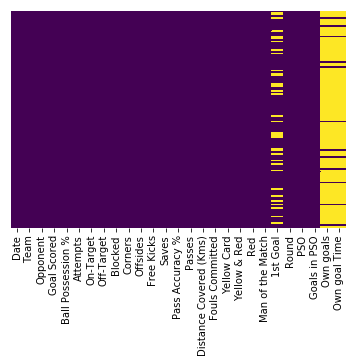

In [88]:
heat_map = sns.heatmap(fifa.isnull(), yticklabels = False,
            cbar = False,
            cmap = 'viridis')

### Drop columns where we can't impute missing values ('Own goal Time', '1st Goal') or that intuitively don't have predictive power (such as 'Date')

In [7]:
fifa = fifa.drop(['1st Goal', 'Own goal Time', 'Date', 'Team', 'Opponent', 'Round'], axis = 1)

### Clean up missing values in own goals (0 will replace NaN since that means no own goals were scored) and dummy encode our two categorical variables

In [4]:
fifa['Own goals'] = fifa['Own goals'].fillna(0).astype(int)
fifa['PSO'] = pd.get_dummies(fifa.PSO).Yes
fifa['Man of the Match'] = pd.get_dummies(fifa['Man of the Match']).Yes

### Create a column to indicate who won the match. By groups of two rows, decide who got the maximum score within a game and assign 1 for winners and 0 for losers

In [62]:
game_group = [n for n in range(len(fifa)//2)]
game_group = np.repeat(game_group, 2)

fifa['winner'] = fifa.groupby(game_group)['Goal Scored'].transform(lambda x: x == max(x))
fifa['winner'] = fifa['winner'].map({True: 1, False: 0})

### Separate the outcome variable from the predictors

In [8]:
fifa_x = fifa.drop('Man of the Match', axis = 1)
fifa_y = fifa['Man of the Match']

### What kind of relationships exist within the data? Looking at distributions for each variable, separated by winners and losers of Man of the Match

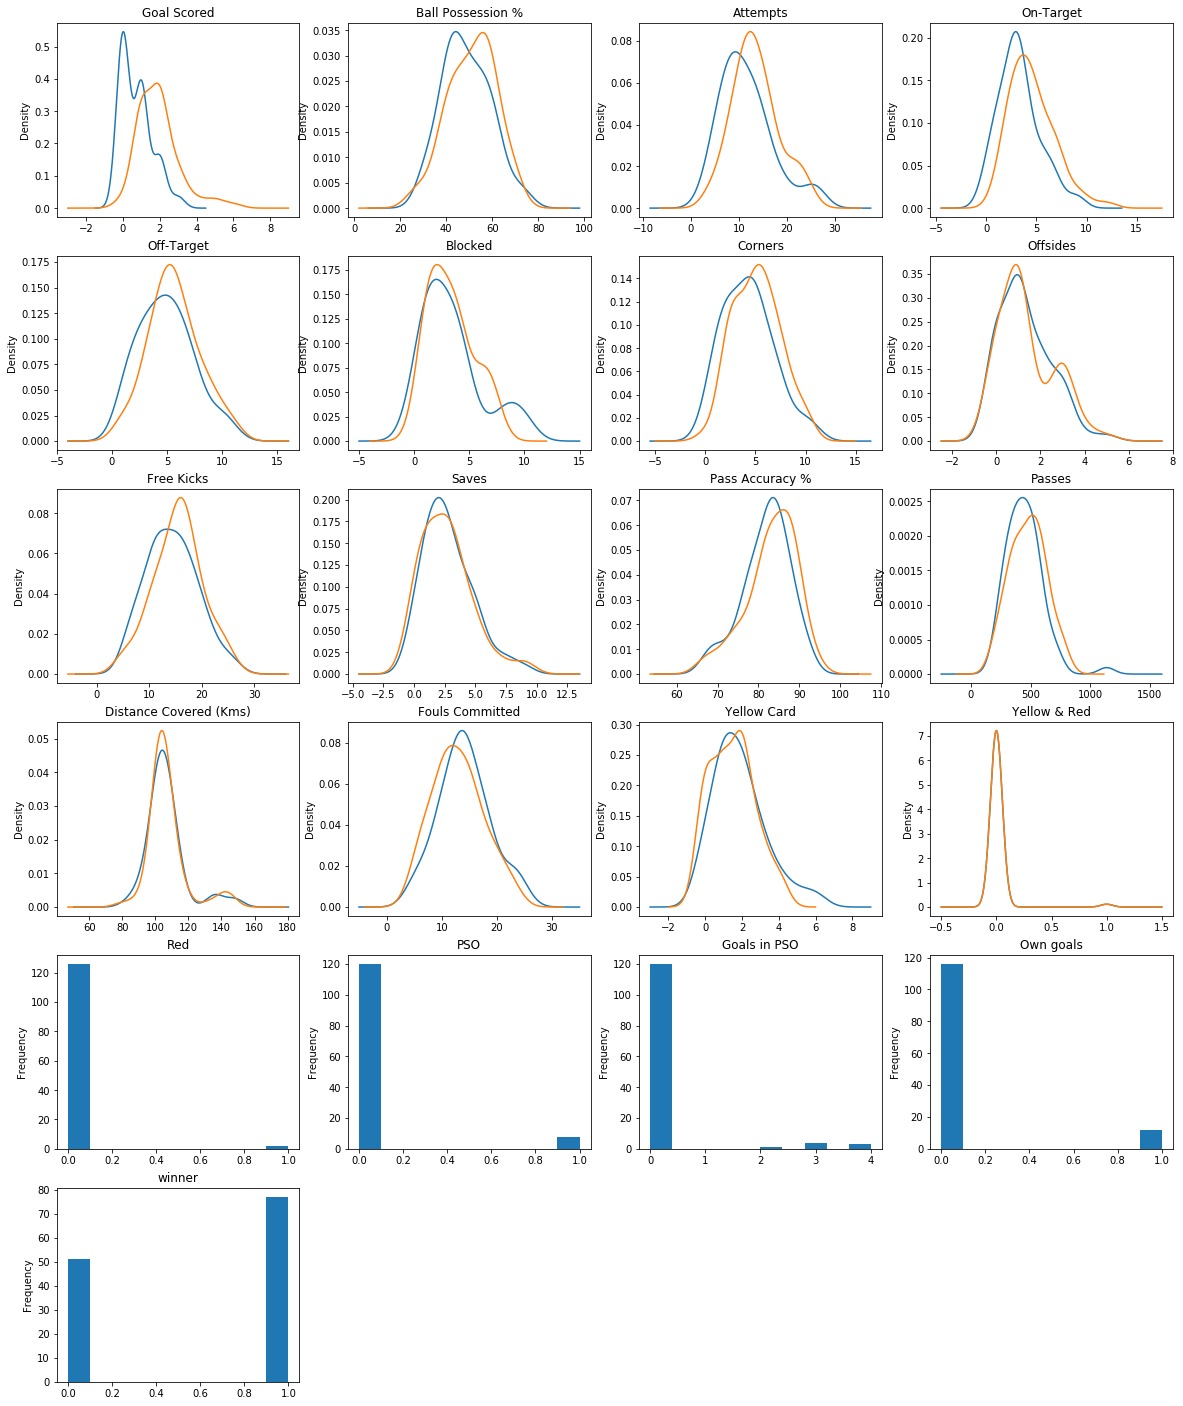

In [9]:
f = plt.figure(figsize = (20, 25))

## Add a density plot for each of the continuous predictors
for i in range(0, 16):
    f.add_subplot(6, 4, i + 1)
    fifa.iloc[:, i].groupby(fifa_y).plot(kind = 'kde', title = fifa.columns[i])
    
## Add frequency plots for each of the categorical variables
for n, i in enumerate([16, 18, 19, 20, 21]):
    
    f.add_subplot(6, 4, n + 17)
    fifa.iloc[:, i].plot(kind = 'hist', x = ['win' if n == 1 else 'lose' for n in fifa_y], title = fifa.columns[i])
    
plt.show()

In [10]:
scaler = StandardScaler()
fifa_x = scaler.fit_transform(fifa_x)
fifa_x = pd.DataFrame(fifa_x)

In [11]:
xtrain, xtest, ytrain, ytest = train_test_split(fifa_x, 
                                                fifa_y, 
                                                random_state = 42, 
                                                test_size = .33,
                                                stratify = fifa_y)

In [12]:
log_reg = LogisticRegression()
log_reg.fit(xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [13]:
preds = log_reg.predict(xtest)
print(confusion_matrix(preds, ytest))
print(accuracy_score(preds, ytest))

[[16  3]
 [ 6 18]]
0.7906976744186046


In [14]:
errors_knn = pd.DataFrame(columns = ['n_value', 'train_error', 'test_error'])

for n in range(1, len(xtrain)):
    knn_clf = knn(n_neighbors = n)
    knn_clf.fit(X = xtrain, y = ytrain)
    
    preds = knn_clf.predict(xtrain)
    errors_knn.loc[n, 'train_error'] = accuracy_score(preds, ytrain)
    
    preds = knn_clf.predict(xtest)
    errors_knn.loc[n, 'test_error'] = accuracy_score(preds, ytest)

In [15]:
preds = knn_clf.predict(xtest)
print(confusion_matrix(preds, ytest))
print(accuracy_score(preds, ytest))

[[ 5  7]
 [17 14]]
0.4418604651162791


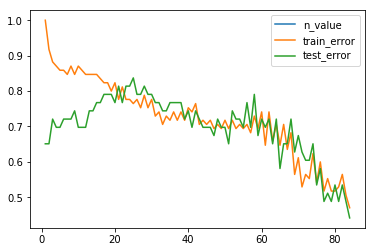

In [16]:
errors_knn.plot()
plt.show()

In [54]:
mlp_clf = mlp()

grid = {'hidden_layer_sizes': [(10, 10), (20, 10), (30, 10),
                               (10, 20), (20, 20), (30, 20),
                               (10, 30), (20, 30), (30, 30)], 
        'max_iter': [1000, 2000], 
        'learning_rate_init': [1e-10, 1e-5, 1e-3, 1e-2, 1e-1],
        'random_state': [420]}
grid_mlp = gs(mlp_clf, grid, cv = 10)

grid_mlp.fit(xtrain, ytrain)

/Users/kmertan/miniconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/kmertan/miniconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/kmertan/miniconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/kmertan/miniconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization h

GridSearchCV(cv=10, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'hidden_layer_sizes': [(10, 10), (20, 10), (30, 10), (10, 20), (20, 20), (30, 20), (10, 30), (20, 30), (30, 30)], 'max_iter': [1000, 2000], 'learning_rate_init': [1e-10, 1e-05, 0.001, 0.01, 0.1], 'random_state': [420]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [75]:
model_output(grid_mlp)

Best mean CV accuracy:  0.8941176470588236
Holdout test set accuracy:  0.7674418604651163
Best parameters:  {'criterion': 'gini', 'max_depth': None, 'n_estimators': 500, 'random_state': 69}


In [71]:
rand_for = rf()

grid = {'n_estimators': [5, 10, 15, 20, 30, 50, 100, 200, 500],
        'max_depth' : [None, 2, 3, 5, 10, 20],
        'criterion': ['gini', 'entropy'],
        'random_state' : [69]}

grid_rand = gs(rand_for, grid, cv = 10)

grid_rand.fit(xtrain, ytrain)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 15, 20, 30, 50, 100, 200, 500], 'max_depth': [None, 2, 3, 5, 10, 20], 'criterion': ['gini', 'entropy'], 'random_state': [69]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [74]:
model_output(grid_rand)

Best mean CV accuracy:  0.8941176470588236
Holdout test set accuracy:  0.7674418604651163
Best parameters:  {'criterion': 'gini', 'max_depth': None, 'n_estimators': 500, 'random_state': 69}


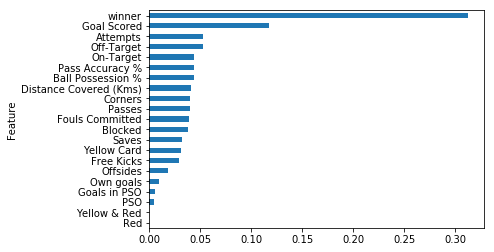

In [51]:
feat_imp_rf = pd.DataFrame({'Feature' : fifa.drop('Man of the Match', axis = 1).columns,
                            'Importance' : grid_rand.best_estimator_.feature_importances_})

feat_imp_rf.set_index('Feature', inplace = True)
feat_imp_rf.sort_values('Importance', inplace = True)

feat_imp_rf.plot(kind = 'barh', legend = None)
plt.show()

In [68]:
joblib.dump(grid_rand, 'fifa_rf.pkl')